In [1]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Build data
This data is naturally for english to french MT  
https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html

In [4]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ['train.en.gz']
val_urls = ['val.en.gz']
test_urls = ['test_2016_flickr.en.gz']

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]


### Build vocab
At this point we need to generate the tokens, that is, both the n-gram tokens and the full word tokens.
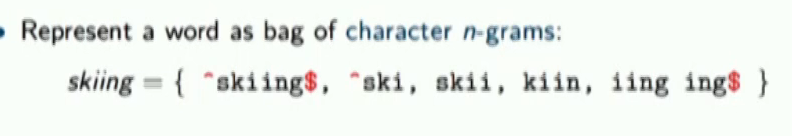
Source: https://vimeo.com/234958672

In [83]:
def word2subword(word_token_string, N_GRAMS=3, pad_token = '<pad>', max_len=0):
    """
    word2subword('hello')
    >>> ['<hello>', '<he', 'hel', 'ell', 'llo', 'lo>']
    """
    full_word_w_sos_eos = '<'+word_token_string+'>'
    list_of_subword_tokens = [full_word_w_sos_eos]
    if len(word_token_string) > N_GRAMS:
        list_of_subword_tokens += [full_word_w_sos_eos[i:i+N_GRAMS] for i in range(len(full_word_w_sos_eos)+1-N_GRAMS)]
    
    if max_len>0:
        list_of_subword_tokens = list_of_subword_tokens[:max_len] + [pad_token]*max(max_len-len(list_of_subword_tokens),0)
    return list_of_subword_tokens

word2subword('hello', max_len=0)
word2subword('hello', max_len=4)

['<hello>', '<he', 'hel', 'ell']

In [6]:
# de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

def build_vocab(filepath, tokenizer):
    subword_counter, fullword_counter = Counter(), Counter()
    list_of_sentences, all_text = [], []
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            # e.g. ['A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '\n']
            list_of_word_tokens = tokenizer(string_)
            list_of_sentences.append(list_of_word_tokens)
            
            # full text and full word token for skipgram sampling later
            all_text.extend(list_of_word_tokens)
            fullword_counter.update(list_of_word_tokens)
            
            # update subword token
            for word_token in list_of_word_tokens:
                subtokens = word2subword(word_token)
                subword_counter.update(subtokens)
                
    subword_vocab = Vocab(subword_counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    fullword_vocab = Vocab(fullword_counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    return subword_vocab, fullword_vocab, len(fullword_vocab.stoi), list_of_sentences, all_text

en_vocab, fullword_vocab, vocab_size, list_of_sentence_tokens, all_text = build_vocab(train_filepaths[0], en_tokenizer)
print(f"full word vocab size: {vocab_size}")
# list_of_sentence_tokens[:1]

full word vocab size: 10840


### Generate skipgram pairs
Tensorflow Keras provides a way to draw words for negative sampling.  
https://www.tensorflow.org/tutorials/text/word2vec  
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/
```
%time couples, labels = skipgrams(all_text, vocabulary_size=vocab_size, window_size=WINDOW_SIZE)
CPU times: user 43.4 s, sys: 370 ms, total: 43.8 s
Wall time: 43.7 s```

In [7]:
WINDOW_SIZE = 4

from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
sampling_table = make_sampling_table(vocab_size)

couples, labels = skipgrams(
      all_text, 
      vocabulary_size=vocab_size,
      window_size=WINDOW_SIZE,
    )
couples[:10]

[['on', 7764],
 ['temple', 3134],
 ['in', 343],
 ['three', 'in'],
 ['black', 8467],
 ['on', 'subway'],
 ['video', '\n'],
 ['has', 2288],
 ['something', 5375],
 ['Woman', 1620]]

In [8]:
labels[:10]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0]

`couples` contain the pair of words, whereas `labels` contain the binary labels to run the loss against.  
### Create custom data loader

In [9]:
from torch.utils.data import Dataset, DataLoader

class neg_sampling_dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, couples, labels, fullword_vocab):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.couples = couples
        self.labels = labels
        self.fullword_vocab = fullword_vocab
        assert len(couples) == len(labels), f"number of word pairs and labels do not match {len(couples)} vs {len(labels)}"

    def __len__(self):
        return len(self.labels)
    
    def _idx2word(self, idx):
        if type(idx) == int:
            return self.fullword_vocab.itos[idx]
        elif type(idx) == str:
            return idx
        else:
            raise TypeError(f"unrecognized type {type(idx)}")
    
    def __getitem__(self, idx):
        couple = self.couples[idx]
        couple = [self._idx2word(word) for word in couple]
        label = self.labels[idx]
        return couple, label
        

dataset = neg_sampling_dataset(couples, labels, fullword_vocab)
dataloader = enumerate(DataLoader(dataset, batch_size=2))

# to use
for idx, (couples_batch, labels_batch) in dataloader:
    pass
    break

### Model
`en_vocab` will contain the dictionary and `word2subword` is the function to encode whole word strings.

In [379]:
import os
import pickle

import torch.nn as nn
import torch.nn.functional as F


class subword_tokenizer(nn.Module):
    def __init__(self, stoi={'<unk>':0}, embed_dim=200):
        super().__init__()
        self.stoi = stoi
        self.embed_dim = embed_dim
        self.vocab_size = len(self.stoi)
        # self.max_len = max_len
        
        self.embedding = nn.EmbeddingBag(self.vocab_size, self.embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim * 2, 2)
        self.init_weights()
        self.criterion = torch.nn.CrossEntropyLoss() #.to(device)
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def str2id(self, text):
        # get token ids
        subword_tokens = word2subword(text)
        subword_tokens_id = [self.stoi[subword_token] for subword_token in subword_tokens]
        return subword_tokens_id
        
    def forward(self, list_of_words):
        if type(list_of_words)==str:
            list_of_words=[list_of_words]
        
        # form a 1d array of the wordpiece ids
        # store a list of offsets to separate the words out
        token_ids, offsets, offset = [], [], 0
        for word in list_of_words:
            offsets.append(offset)
            token_id = self.str2id(word)
            token_ids.extend(token_id)
            offset += len(token_id)
        token_ids = torch.LongTensor(token_ids)
        
        # feed the ids into embedding
        encoding = self.embedding(token_ids, offsets=torch.tensor(offsets))
        return encoding
        
    def batch_forward(self, batch_of_couples, labels):
        # get word pair encodings
        word1s = self(batch_of_couples[0])
        word2s = self(batch_of_couples[1])
        word12_concat = torch.cat((word1s, word2s), axis=1)
        
        # get loss from labels
        labels = torch.tensor(labels)
        logits = self.fc(word12_concat)
        loss = self.criterion(logits, labels)
        
        return loss, logits

    def save(self, path):
        if not os.path.isdir(path):
            os.makedirs(path)
        torch.save({'model':self.state_dict(), 
                    'embed_dim':self.embed_dim, 
                    'stoi':self.stoi}, 
                   path+'/state.pt')
        
    def restore(self, path):
        state = torch.load(path+'/state.pt')
        
        # 1. load vocab
        self.stoi = defaultdict(int,state['stoi'])
        self.vocab_size = len(self.stoi)
        
        # 2. load model params
        self.embed_dim = state['embed_dim']
        
        # 3. reinit the layers and load weights
        self.embedding = nn.EmbeddingBag(self.vocab_size, self.embed_dim, sparse=True)
        self.fc = nn.Linear(self.embed_dim * 2, 2)
        self.load_state_dict(state['model'])
        
        
model = subword_tokenizer(en_vocab.stoi, 20)
model(['hello', 'there'])

In [222]:
model.batch_forward(couples_batch, labels_batch)

/home/vinitrinh/anaconda3/envs/gr3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor(0.7394, grad_fn=<NllLossBackward>),
 tensor([[ 0.0289, -0.9491],
         [ 0.2174,  0.7545],
         [-0.1217, -0.2038],
         [-0.1886, -0.2458],
         [ 0.7474,  0.1249],
         [-0.5357,  0.3844],
         [-0.1911, -0.0603],
         [ 0.7020, -0.5899],
         [-0.0058,  0.2562],
         [-0.2619,  0.0257],
         [ 0.1017, -0.3087],
         [ 0.0933,  0.2049],
         [-0.2507,  0.4094],
         [-0.8175,  0.2188],
         [-0.3063, -0.9152],
         [-1.1565,  0.5498],
         [ 0.0083, -0.3731],
         [ 0.0039,  0.0956],
         [ 0.3265,  0.2031],
         [ 0.1261, -0.2501],
         [ 0.2584, -0.0982],
         [ 0.7487, -1.4199],
         [-0.4959, -0.8109],
         [-0.2556,  0.1684],
         [-0.4567,  0.0276],
         [-0.1418,  0.3523],
         [-0.2446,  0.0257],
         [-0.0355, -0.0644],
         [ 0.8979, -0.6735],
         [-0.5508,  0.0262],
         [-0.3795, -0.2195],
         [ 0.5750, -0.1560],
         [ 0.0520, -0.1855],

### Training

In [223]:
model = subword_tokenizer(en_vocab, 20)

In [224]:
N_EPOCHS=5

dataset = neg_sampling_dataset(couples, labels, fullword_vocab)
dataloader = DataLoader(dataset, batch_size=40)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

for epoch in range(N_EPOCHS):
    train_loss, train_acc = 0, 0
    print(f"epoch: {epoch}")
        
    # try removing tqdm
    for idx, (couples_batch, labels_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        loss, logits = model.batch_forward(couples_batch, labels_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (logits.argmax(1) == labels_batch).sum().item()    
    
    
    scheduler.step()
    print(f" {train_loss / len(dataset)}, {train_acc / len(dataset)}")

epoch: 0


/home/vinitrinh/anaconda3/envs/gr3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 0.010603299391716963, 0.8029921172285783
epoch: 1
 0.008648978741090628, 0.8558075105667751
epoch: 2
 0.008023853999234989, 0.8714374174422966
epoch: 3
 0.007670886836149611, 0.8800278481414817
epoch: 4
 0.007438060795406326, 0.8850114007529629


List comprehension timings:
```
%time model( ['hello', 'there'] )
CPU times: user 0 ns, sys: 3.39 ms, total: 3.39 ms
Wall time: 1.87 ms
```
```
%time model( ['hello', 'there']*100 )
CPU times: user 22.8 ms, sys: 4.03 ms, total: 26.8 ms
Wall time: 25.8 ms
```

Batch processing timings:
```
%time model( ['hello', 'there'] )
CPU times: user 35.3 ms, sys: 0 ns, total: 35.3 ms
Wall time: 13.3 ms
```
```
%timeit model( ['hello', 'there']*100 )
CPU times: user 36.2 ms, sys: 59 µs, total: 36.3 ms
Wall time: 17.7 ms
```
Therefore, we can only reap the benefits when we put in large batch sizes. 

### Inference
Testing `'scarcity'` on related and unrelated words. 

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [47]:
word1 , word2 = 'rarity', 'scarcity'
cosine_similarity(model(word1).detach().numpy(), model(word2).detach().numpy())

array([[0.57939446]], dtype=float32)

In [45]:
word1 , word2 = 'tomb', 'scarcity'
cosine_similarity(model(word1).detach().numpy(), model(word2).detach().numpy())

array([[-0.08790906]], dtype=float32)

In [46]:
word1 , word2 = 'wash', 'scarcity'
cosine_similarity(model(word1).detach().numpy(), model(word2).detach().numpy())

array([[0.04875937]], dtype=float32)

In [48]:
word1 , word2 = 'terrify', 'scarcity'
cosine_similarity(model(word1).detach().numpy(), model(word2).detach().numpy())

array([[-0.11874171]], dtype=float32)

In [53]:
word1 , word2 = 'willing', 'scarcity'
cosine_similarity(model(word1).detach().numpy(), model(word2).detach().numpy())

array([[0.03372336]], dtype=float32)

### Plot Array

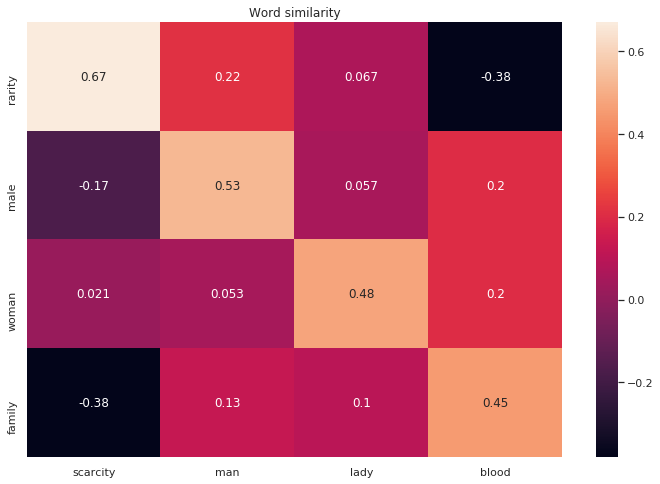

In [304]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

word1s = ['rarity', 'male', 'woman', 'family']
word2s = ['scarcity', 'man','lady', 'blood']

sim_array = cosine_similarity( model(word1s).detach().numpy(),  model(word2s).detach().numpy() )
sim_array = pd.DataFrame(sim_array, columns=word2s, index=word1s)
plt.title('Word similarity')
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.heatmap(sim_array, annot=True)

### Save restore test

In [364]:
# init dummy model
saveload = subword_tokenizer(en_vocab.stoi)
saveload.save('test')

#  test restore
saveload2 = subword_tokenizer()
saveload2.restore('test')
cosine_similarity(saveload('hello').detach().numpy(), saveload2('hello').detach().numpy())

array([[0.99999994]], dtype=float32)